In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#configure
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style = 'whitegrid', color_codes=True)

#modelSelection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#import dl Libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Activation,Dropout,Flatten
from keras.layers import MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import numpy as np
import cv2 
import os
from tqdm import tqdm
from random import shuffle
from PIL import Image
from zipfile import ZipFile




#2 ) Preparing the Data¶


In [3]:
# 2.1) Making the functions to get the training and validation set from the Images.

X =[]
Z =[]
IMG_SIZE = 150

FLOWER_DAISY_DIR=(r'D:\Project\DL\Flower\flowers\daisy')
FLOWER_SUNFLOWER_DIR=(r'D:\Project\DL\Flower\flowers\sunflower')
FLOWER_TULIP_DIR=(r'D:\Project\DL\Flower\flowers\tulip')
FLOWER_DANDI_DIR=(r'D:\Project\DL\Flower\flowers\dandelion')
FLOWER_ROSE_DIR=(r'D:\Project\DL\Flower\flowers\rose')


In [4]:
def assign_label(img, flower_type):
    return flower_type

In [5]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize (img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [6]:
make_train_data('Daisy', FLOWER_DAISY_DIR )
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 764/764 [00:01<00:00, 406.21it/s]

764


In [7]:
make_train_data('sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 733/733 [00:02<00:00, 332.75it/s]

1497


In [8]:
make_train_data('tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 984/984 [00:02<00:00, 372.58it/s]

2481


In [9]:
make_train_data('dandi',FLOWER_DANDI_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:02<00:00, 384.03it/s]

3533


In [10]:
make_train_data('rose',FLOWER_ROSE_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 784/784 [00:01<00:00, 400.13it/s]

4317


2.2 ) Visualizing some Random Images

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [14]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

2.4 ) Splitting into Training and Validation Sets

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


2.5) Setting the Random Seeds

In [18]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)


# 3 ) Modelling

3.1 ) Building the ConvNet Model

In [21]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D( filters=32, kernel_size= (5,5), padding ='same', activation='relu',input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 96, kernel_size= (2,2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size= (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation= "softmax"))

3.2 ) Using a LR Annealer

In [73]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor = 'value_acc', patience = 3,verbose =1,factor=0.1 )

3.3 ) Data Augmentation to prevent Overfitting


In [76]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip= False
)

datagen.fit(X_train)


In [77]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


In [78]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 96)          │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,981,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,113,029 (15.69 MB)

 Trainable params: 4,113,029 (15.69 MB)

 Non-trainable params: 0 (0.00 B)

3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [83]:
History = model.fit(datagen.flow(X_train,y_train, batch_size = batch_size),
                             epochs = epochs, validation_data = (X_test,y_test),
                             verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6823 - loss: 0.8180 - val_accuracy: 0.7250 - val_loss: 0.6934
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.7188 - loss: 0.8049 - val_accuracy: 0.7370 - val_loss: 0.6790
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7489 - loss: 0.6654 - val_accuracy: 0.7463 - val_loss: 0.6306
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7969 - loss: 0.5596 - val_accuracy: 0.7528 - val_loss: 0.6246
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7715 - loss: 0.6092 - val_accuracy: 0.7407 - val_loss: 0.6718
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6757 - loss: 0.6870 - val_accuracy: 0.7370 - val_loss: 0.6605
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7580 - loss: 0.6526 - val_accuracy: 0.7259 - val_loss: 0.7251
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7812 - loss: 0.6002 - val_accuracy: 0.7259 - val_l

# 4 ) Evaluating the Model Performance

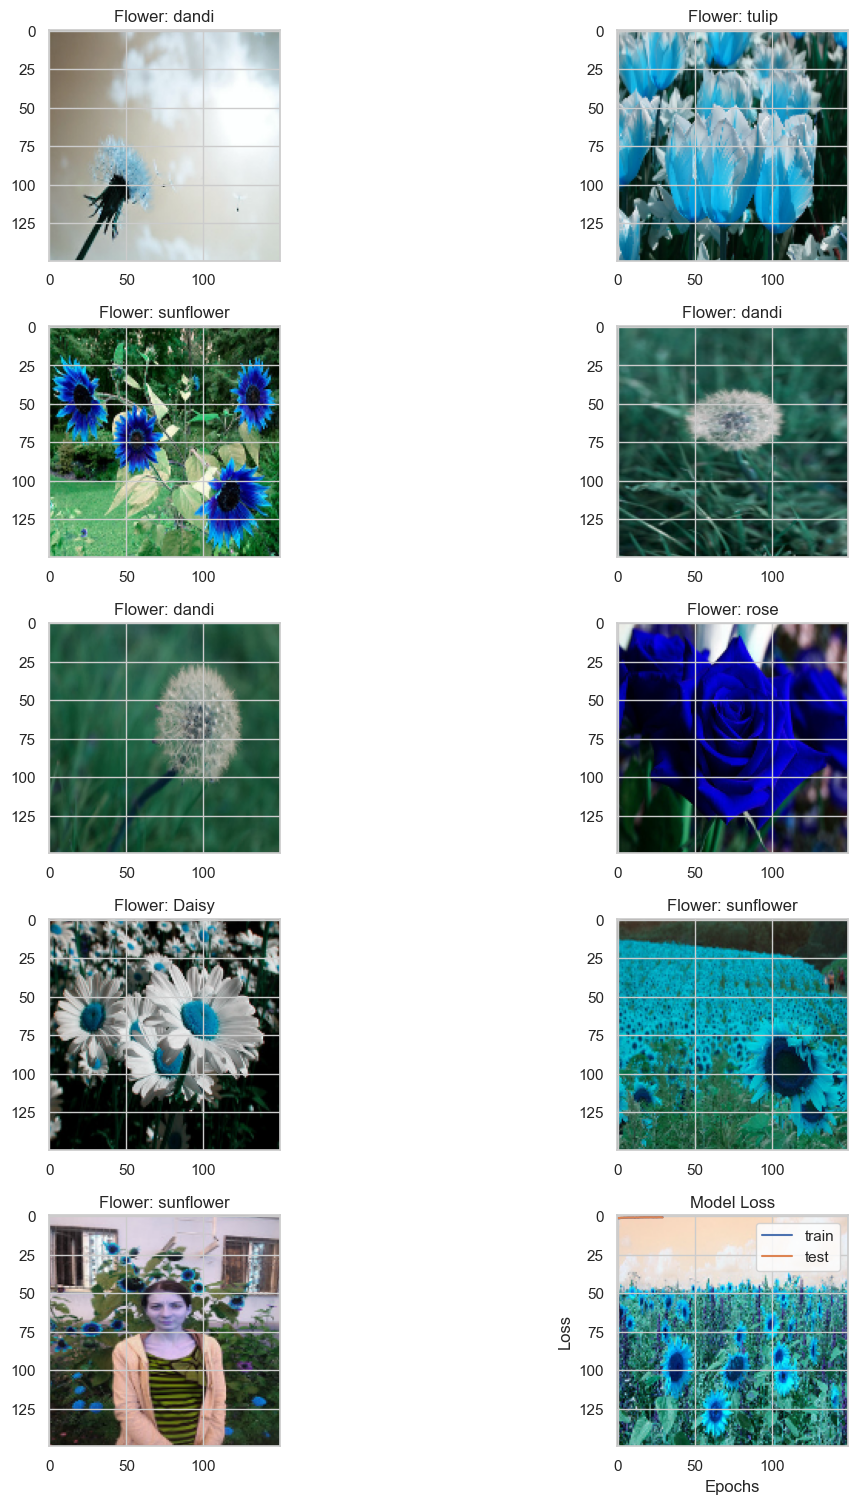

In [31]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

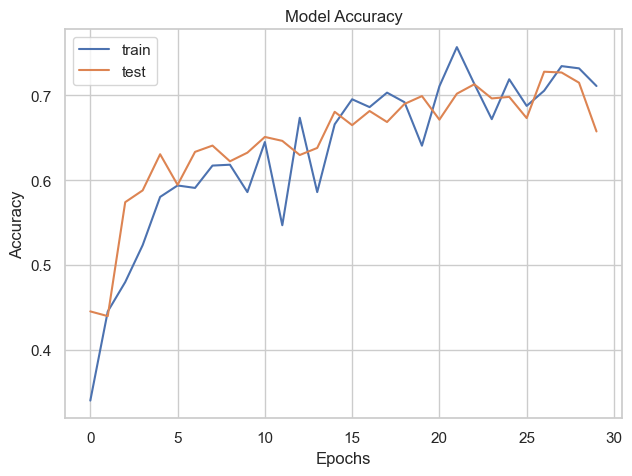

In [32]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# 5 ) Visualizing Predictons on the Validation Set

In [34]:
pred = model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


In [35]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# CORRECTLY CLASSIFIED FLOWER IMAGES

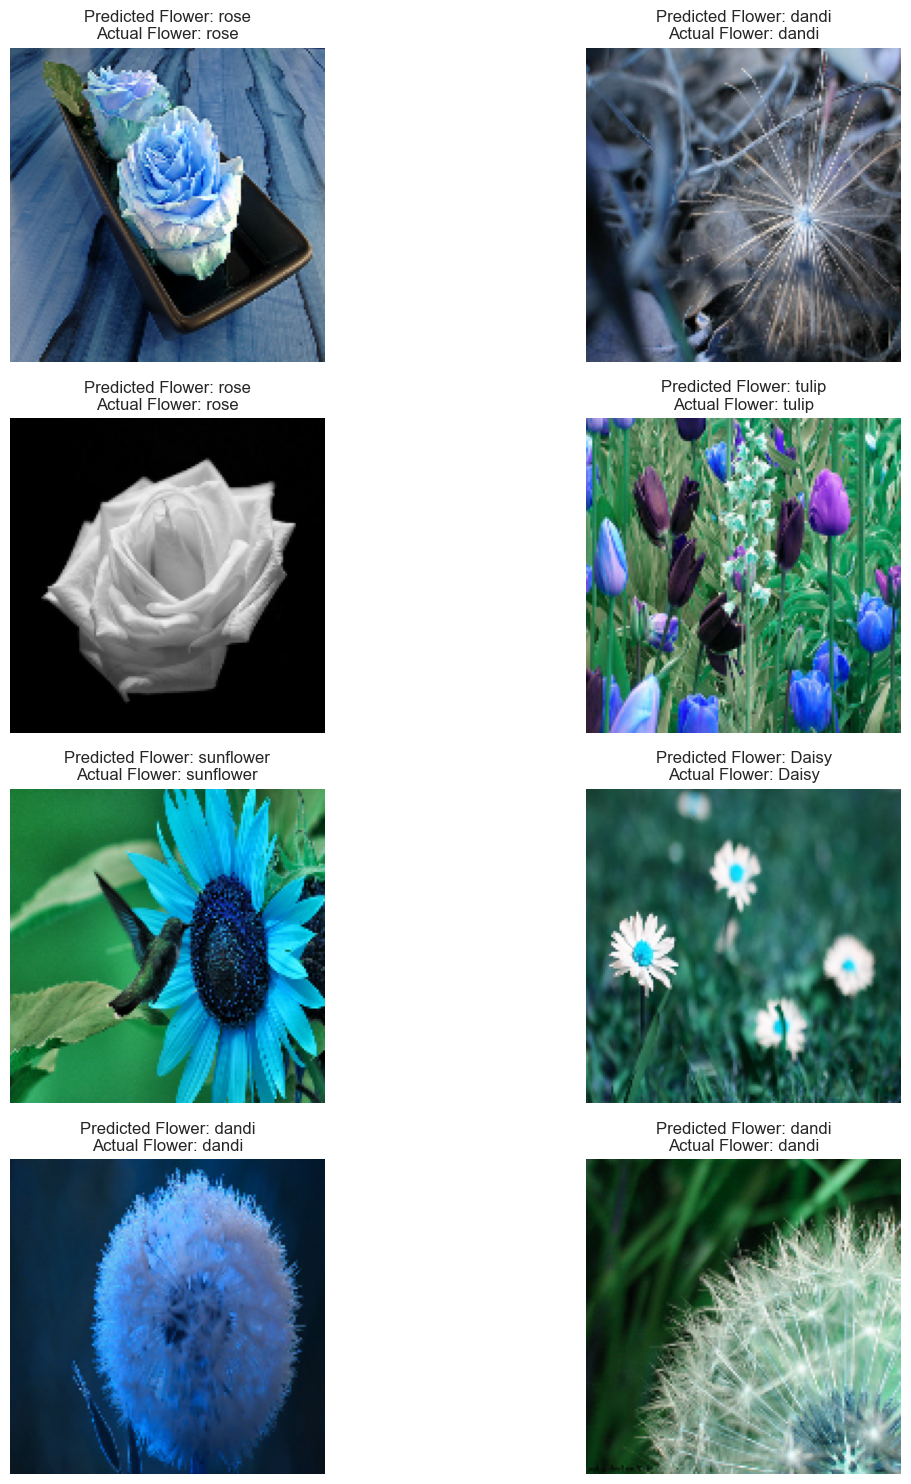

In [37]:
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2, figsize=(15, 15))  # figsize instead of set_size_inches for consistency
for i in range(4):
    for j in range(2):
        if count < len(prop_class):  # Ensure count is within the bounds of mis_class
            # Convert mis_class[count] to an integer
            index = int(prop_class[count])  # Ensure the index is an integer

            # Display the image
            ax[i, j].imshow(X_test[index])

            # Ensure that y_test[index] is a scalar (in case it's an array)
            actual_label = y_test[index] if np.ndim(y_test[index]) == 0 else y_test[index].argmax()

            # Get the predicted label
            predicted_label = le.inverse_transform([pred_digits[index]])[0]  # Get the predicted label
            actual_label = le.inverse_transform([actual_label])[0]  # Get the actual label

            ax[i, j].set_title(
                "Predicted Flower: " + str(predicted_label) + "\n" +
                "Actual Flower: " + str(actual_label))
            ax[i, j].axis('off')  # Optionally, turn off axis for better visual appearance
        count += 1

plt.tight_layout()
plt.show()


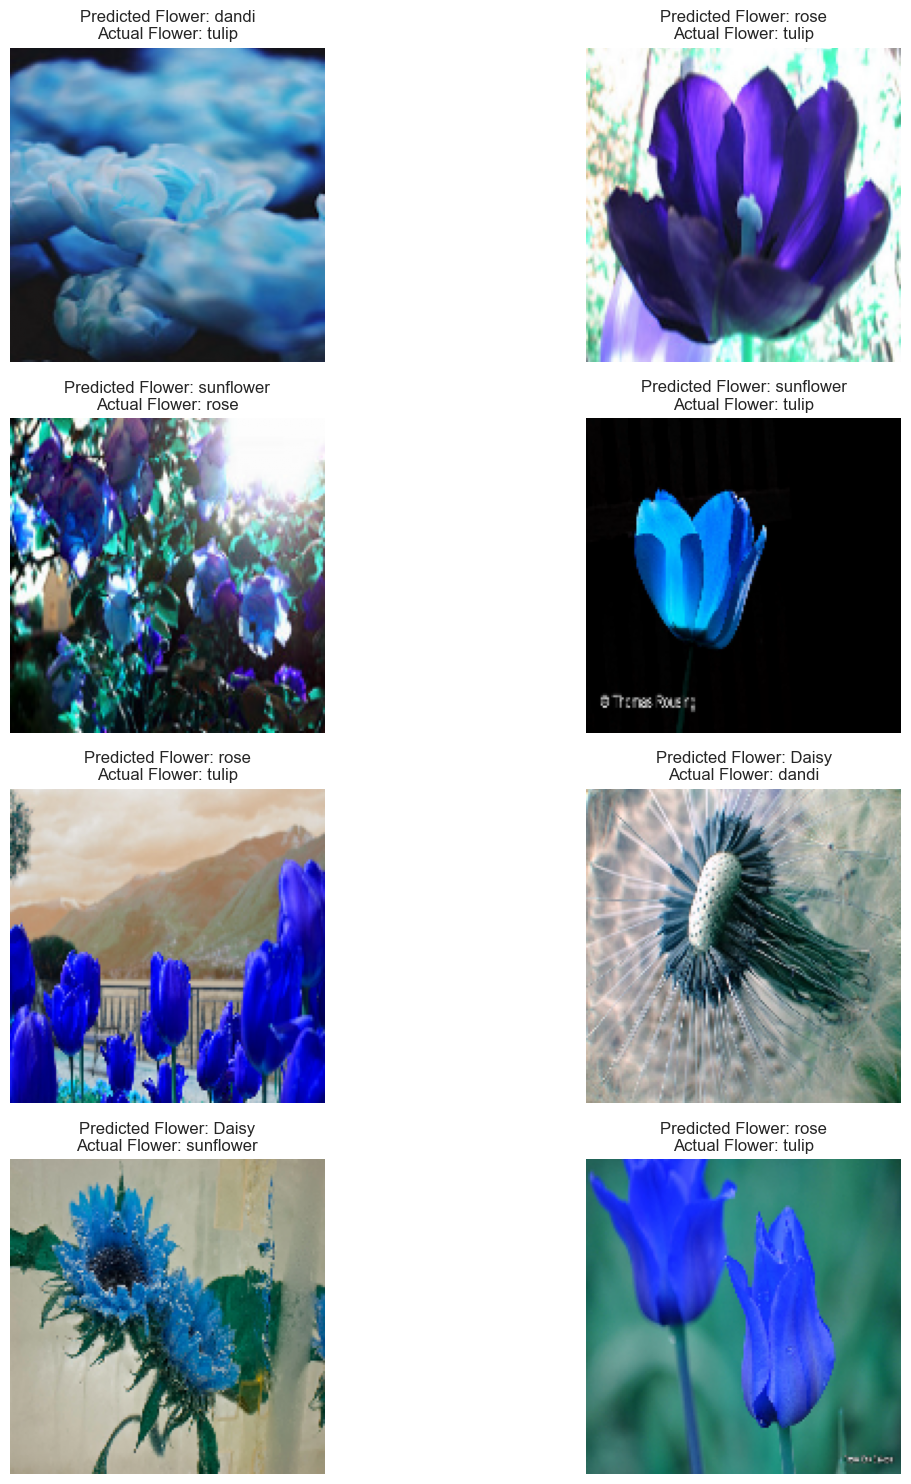

In [38]:
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2, figsize=(15, 15))  # figsize instead of set_size_inches for consistency
for i in range(4):
    for j in range(2):
        if count < len(mis_class):  # Ensure count is within the bounds of mis_class
            # Convert mis_class[count] to an integer
            index = int(mis_class[count])  # Ensure the index is an integer

            # Display the image
            ax[i, j].imshow(X_test[index])

            # Ensure that y_test[index] is a scalar (in case it's an array)
            actual_label = y_test[index] if np.ndim(y_test[index]) == 0 else y_test[index].argmax()

            # Get the predicted label
            predicted_label = le.inverse_transform([pred_digits[index]])[0]  # Get the predicted label
            actual_label = le.inverse_transform([actual_label])[0]  # Get the actual label

            ax[i, j].set_title(
                "Predicted Flower: " + str(predicted_label) + "\n" +
                "Actual Flower: " + str(actual_label))
            ax[i, j].axis('off')  # Optionally, turn off axis for better visual appearance
        count += 1

plt.tight_layout()
plt.show()
